In [71]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

In [72]:
stock_relation = pd.read_csv("../dataset/news/relation_all.csv")
stock_relation['time'] = pd.to_datetime(stock_relation['time'])
stock_relation

,ticker,sentiment,sentiment_reasoning,news_id,source_ticker,time
0,NFLX,positive,The article indicates that significant investo...,d913f8609f0266a3934c767e3e08b5cb3a5b907373cf4c...,NFLX,2024-07-02 17:46:38
1,AMZN,positive,AWS is mentioned as one of the biggest names i...,8acd1c36c41725f571ef8611bcecdb9223800381a2543b...,MSFT,2024-07-02 17:46:57
2,MSFT,positive,Microsoft is mentioned as one of the prominent...,8acd1c36c41725f571ef8611bcecdb9223800381a2543b...,GOOGL,2024-07-02 17:46:57
3,GOOG,positive,Google is also mentioned as one of the promine...,8acd1c36c41725f571ef8611bcecdb9223800381a2543b...,GOOGL,2024-07-02 17:46:57
4,GOOGL,positive,Google is also mentioned as one of the promine...,8acd1c36c41725f571ef8611bcecdb9223800381a2543b...,GOOGL,2024-07-02 17:46:57
...,...,...,...,...,...,...
25522,META,neutral,The article mentions Meta Platforms' developme...,1d9a233266513e7565c8aa26700bc8a7fad1acb0eb8f8f...,NVDA,2024-10-31 04:26:28
25523,AMD,positive,The article highlights AMD CEO Lisa Su's optim...,1d9a233266513e7565c8aa26700bc8a7fad1acb0eb8f8f...,NVDA,2024-10-31 04:26:28
25524,NVDA,neutral,The article acknowledges NVIDIA as a major com...,1d9a233266513e7565c8aa26700bc8a7fad1acb0eb8f8f...,META,2024-10-31 04:26:28
25525,META,neutral,The article mentions Meta Platforms' developme...,1d9a233266513e7565c8aa26700bc8a7fad1acb0eb8f8f...,META,2024-10-31 04:26:28


In [73]:
stock_relation['sentiment'].value_counts()

sentiment
positive    15321
neutral      7369
negative     2684
bearish        74
hold           42
bullish        32
mixed           5
Name: count, dtype: int64

In [74]:
ticker = 'META'

In [75]:
stock_price = pd.read_csv(f"../dataset/stocks/{ticker}.csv")
stock_price['time'] = pd.to_datetime(stock_price['time'])
stock_price['trade_date'] = stock_price['time'].dt.date
stock_price['delta'] = stock_price['close'].diff()
stock_price['prv_close'] = stock_price['close'].shift(periods=1, fill_value=None)
stock_price

,volumn,vwap,open,close,high,low,time,num_trades,trade_date,delta,prv_close
0,121136644.0,94.2319,98.220,93.16,99.3200,92.600,2022-10-31 04:00:00,951643,2022-10-31,NaN,NaN
1,110094417.0,95.4630,94.330,95.20,97.4900,93.550,2022-11-01 04:00:00,735796,2022-11-01,2.04,93.16
2,71794472.0,92.9141,94.205,90.54,95.2000,90.480,2022-11-02 04:00:00,587097,2022-11-02,-4.66,95.20
3,60664012.0,89.3570,90.080,88.91,90.4576,88.410,2022-11-03 04:00:00,503016,2022-11-03,-1.63,90.54
4,55605061.0,89.7507,90.350,90.79,91.3900,88.090,2022-11-04 04:00:00,437599,2022-11-04,1.88,88.91
...,...,...,...,...,...,...,...,...,...,...,...
497,13985986.0,570.1199,579.970,563.69,585.0000,562.500,2024-10-23 04:00:00,276843,2024-10-23,-18.32,582.01
498,6999863.0,566.5220,567.125,567.78,568.8799,561.520,2024-10-24 04:00:00,163274,2024-10-24,4.09,563.69
499,11027861.0,575.6534,573.935,573.25,581.2900,571.720,2024-10-25 04:00:00,211196,2024-10-25,5.47,567.78
500,9888525.0,577.8369,582.000,578.16,583.7499,574.120,2024-10-28 04:00:00,205606,2024-10-28,4.91,573.25


In [76]:
def sentiment_transform(label):
    def func(series):
        return series.isin(label).sum() / series.count()
    return func

In [77]:
def sentiment_score(threshold, gt):
    def func(series):
        if gt:
            return series[series >= threshold].mean()
        else:
            return series[series <= threshold].mean()
    return func

In [78]:
relation_t = stock_relation[stock_relation['ticker'] == ticker]
relation_t['news_date'] = (relation_t['time'] + pd.to_timedelta(0, unit='h')).dt.date
relation_t['same_source'] = (relation_t['source_ticker'] == relation_t['ticker']).astype(int)

relation_t['direct_sentiment'] = relation_t['sentiment']
relation_t.loc[relation_t['same_source'] == 0, 'direct_sentiment'] = 'None'


/var/folders/pj/znl5r0ln0hv_g1yjdthtr3f40000gn/T/ipykernel_4861/192863328.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relation_t['news_date'] = (relation_t['time'] + pd.to_timedelta(0, unit='h')).dt.date
/var/folders/pj/znl5r0ln0hv_g1yjdthtr3f40000gn/T/ipykernel_4861/192863328.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relation_t['same_source'] = (relation_t['source_ticker'] == relation_t['ticker']).astype(int)
/var/folders/pj/znl5r0ln0hv_g1yjdthtr3f40000gn/T/ipykernel_4861/192863328.py:5: 

In [79]:
relation_t['news_id'].value_counts().describe()

count    387.000000
mean       3.149871
std        1.786034
min        1.000000
25%        2.000000
50%        3.000000
75%        5.000000
max        8.000000
Name: count, dtype: float64

<Axes: xlabel='time'>

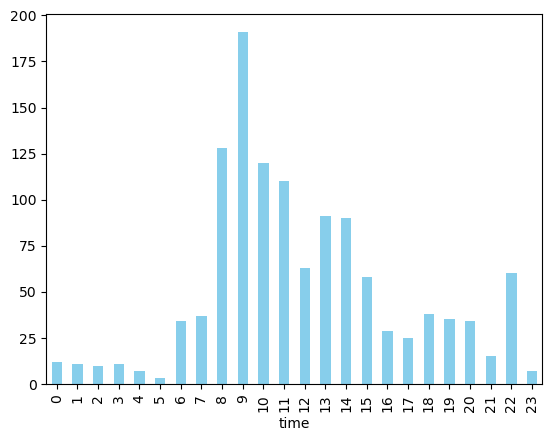

In [80]:
stock_date = relation_t['time'].dt.hour.value_counts().sort_index()
stock_date.plot(kind='bar', color='skyblue')

In [81]:
stock_price['trade_date']

0      2022-10-31
1      2022-11-01
2      2022-11-02
3      2022-11-03
4      2022-11-04
          ...    
497    2024-10-23
498    2024-10-24
499    2024-10-25
500    2024-10-28
501    2024-10-29
Name: trade_date, Length: 502, dtype: object

In [82]:
news_comb = pd.merge(relation_t, stock_price, how='left', left_on='news_date', right_on='trade_date')
# news_comb['trade_date'] = news_comb['trade_date'].fillna(method='bfill')
news_comb.dropna(subset=['trade_date'])
news_comb['direct_sentiment'] = news_comb['sentiment']
news_comb.loc[news_comb['source_ticker'] != news_comb['ticker'], 'direct_sentiment'] = 'None'
news_comb

,ticker,sentiment,sentiment_reasoning,news_id,source_ticker,time_x,news_date,same_source,direct_sentiment,volumn,vwap,open,close,high,low,time_y,num_trades,trade_date,delta,prv_close
0,META,positive,Meta Platforms has also become an important cu...,21be967fb343c874cf942b9abe2cb4089d4500c43dc31b...,META,2024-07-02 18:31:08,2024-07-02,1,positive,7515705.0,506.8472,500.76,509.50,510.50,499.45,2024-07-02 04:00:00,177179.0,2024-07-02,4.82,504.68
1,META,positive,Meta Platforms has also become an important cu...,21be967fb343c874cf942b9abe2cb4089d4500c43dc31b...,GOOGL,2024-07-02 18:31:08,2024-07-02,0,None,7515705.0,506.8472,500.76,509.50,510.50,499.45,2024-07-02 04:00:00,177179.0,2024-07-02,4.82,504.68
2,META,positive,"Meta Platforms aims to become an AI leader, in...",292756ba7e603a197e999f984e4f020f4c4c6424411b51...,NVDA,2024-07-03 09:15:00,2024-07-03,0,None,5924259.0,509.2671,506.37,509.96,511.28,506.02,2024-07-03 04:00:00,137522.0,2024-07-03,0.46,509.50
3,META,positive,"Meta Platforms aims to become an AI leader, in...",292756ba7e603a197e999f984e4f020f4c4c6424411b51...,META,2024-07-03 09:15:00,2024-07-03,1,positive,5924259.0,509.2671,506.37,509.96,511.28,506.02,2024-07-03 04:00:00,137522.0,2024-07-03,0.46,509.50
4,META,positive,"Meta Platforms aims to become an AI leader, in...",292756ba7e603a197e999f984e4f020f4c4c6424411b51...,INTC,2024-07-03 09:15:00,2024-07-03,0,None,5924259.0,509.2671,506.37,509.96,511.28,506.02,2024-07-03 04:00:00,137522.0,2024-07-03,0.46,509.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1214,META,positive,Meta Platforms is planning to spend up to $40 ...,40f6f17a31ea6dce828171990cd72377669fa26cabd02b...,META,2024-10-30 08:57:00,2024-10-30,1,positive,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
1215,META,positive,Meta Platforms is planning to spend up to $40 ...,40f6f17a31ea6dce828171990cd72377669fa26cabd02b...,ORCL,2024-10-30 08:57:00,2024-10-30,0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
1216,META,positive,Meta Platforms is planning to spend up to $40 ...,40f6f17a31ea6dce828171990cd72377669fa26cabd02b...,MSFT,2024-10-30 08:57:00,2024-10-30,0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
1217,META,neutral,The article mentions Meta Platforms' developme...,1d9a233266513e7565c8aa26700bc8a7fad1acb0eb8f8f...,NVDA,2024-10-31 04:26:28,2024-10-31,0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN


In [83]:

relation_gp = news_comb.groupby('trade_date').agg({
    'prv_close': 'first', 'delta': 'first', 'close': 'first',
    'sentiment': [sentiment_transform(['positive', 'bullish']), sentiment_transform(['negative', 'bearish'])],
    'direct_sentiment': [sentiment_transform(['positive', 'bullish']), sentiment_transform(['negative', 'bearish'])],
}).fillna(0.0).reset_index()
relation_gp.columns = ['trade_date', 'prv_close', 'delta', 'close', 'positive', 'negative', 'dir_positive', 'dir_negative']
relation_gp

,trade_date,prv_close,delta,close,positive,negative,dir_positive,dir_negative
0,2024-07-02,504.68,4.82,509.50,1.000000,0.000000,0.500000,0.000000
1,2024-07-03,509.50,0.46,509.96,0.555556,0.037037,0.111111,0.037037
2,2024-07-05,509.96,29.95,539.91,0.871795,0.000000,0.179487,0.000000
3,2024-07-08,539.91,-10.59,529.32,0.666667,0.296296,0.185185,0.074074
4,2024-07-09,529.32,0.68,530.00,0.695652,0.000000,0.217391,0.000000
...,...,...,...,...,...,...,...,...
74,2024-10-22,575.16,6.85,582.01,0.818182,0.000000,0.181818,0.000000
75,2024-10-23,582.01,-18.32,563.69,0.666667,0.333333,0.333333,0.166667
76,2024-10-24,563.69,4.09,567.78,0.166667,0.000000,0.166667,0.000000
77,2024-10-25,567.78,5.47,573.25,1.000000,0.000000,0.166667,0.000000


In [84]:
relation_gp_t = relation_gp[relation_gp['negative'] > 0]
(relation_gp['dir_negative'] > 0).sum(), len(relation_gp_t), len(relation_gp)

(17, 17, 79)

In [85]:
def test_relevance(cols):
    X, y = relation_gp_t[cols], relation_gp_t['delta']
    model = LinearRegression()
    model.fit(X, y)

    # Make predictions
    y_pred = model.predict(X)

    # Evaluate the model
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return mse, r2, model.coef_

In [86]:
test_relevance(['dir_negative', 'prv_close'])

(97.85634249780927, 0.1203039984021006, array([15.36473886,  0.08316732]))

In [87]:
test_relevance(['negative', 'prv_close'])

(99.66642782253646, 0.10403193282036072, array([1.75822447, 0.10048315]))

In [88]:
test_relevance(['dir_negative', 'negative', 'prv_close'])

(96.98796279755913,
 0.12811044334659583,
 array([26.94109737, -5.40397889,  0.08453872]))

In [89]:
test_relevance(['dir_positive', 'prv_close'])

(89.36847893131574, 0.1966070713656135, array([-32.23849173,   0.08756818]))

In [90]:
test_relevance(['dir_negative', 'dir_positive', 'prv_close'])

(88.7412236045335,
 0.20224588831775603,
 array([  8.7295703 , -30.63607932,   0.07515022]))

In [91]:
test_relevance(['dir_negative', 'negative', 'dir_positive', 'prv_close'])

(84.68076612759585,
 0.23874805175392078,
 array([ 33.66843337, -12.34730356, -37.61468389,   0.07645746]))

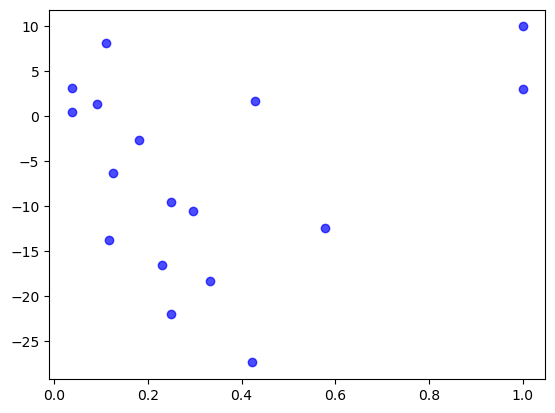

In [92]:
import matplotlib.pyplot as plt

plt.scatter(relation_gp_t['negative'], relation_gp_t['delta'], color='blue', alpha=0.7)

In [93]:

seq_length = 10
std_scaler, max_scaler = StandardScaler(), MinMaxScaler()
score_cols = ['dir_negative', 'negative', 'dir_positive']
price_cols = ['close']

df = pd.DataFrame()
df[score_cols] = std_scaler.fit_transform(relation_gp[score_cols])
df[price_cols] = max_scaler.fit_transform(relation_gp[price_cols])

X = []
y = []
for i in range(seq_length, len(df)):
    X.append(df.iloc[i-seq_length:i])
    y.append(df.iloc[i, -1])
X = np.array(X)
y = np.array(y)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1) 

X.shape, y.shape

(torch.Size([69, 10, 4]), torch.Size([69, 1]))

In [94]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

In [95]:
model = SimpleLSTM(input_size=4, hidden_size=32, output_size=1, dropout=0.2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [96]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/20], Loss: 0.3726
Epoch [2/20], Loss: 0.3632
Epoch [3/20], Loss: 0.3538
Epoch [4/20], Loss: 0.3444
Epoch [5/20], Loss: 0.3351
Epoch [6/20], Loss: 0.3258
Epoch [7/20], Loss: 0.3165
Epoch [8/20], Loss: 0.3072
Epoch [9/20], Loss: 0.2979
Epoch [10/20], Loss: 0.2886
Epoch [11/20], Loss: 0.2793
Epoch [12/20], Loss: 0.2700
Epoch [13/20], Loss: 0.2606
Epoch [14/20], Loss: 0.2512
Epoch [15/20], Loss: 0.2417
Epoch [16/20], Loss: 0.2322
Epoch [17/20], Loss: 0.2226
Epoch [18/20], Loss: 0.2128
Epoch [19/20], Loss: 0.2030
Epoch [20/20], Loss: 0.1931
